In [104]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from matplotlib import cm

np.random.seed(42)

plt.rcParams.update(plt.rcParamsDefault)

### Code for Exercise 4.7


In [105]:
MAX_CARS = 20  # Maximum cars at each location
MAX_MOVE = 5  # Maximum cars that can be moved overnight
RENTAL_CREDIT = 10  # Credit for each rental
MOVE_COST = 2  # Cost to move a car
GAMMA = 0.9  # Discount factor

RENTAL_REQUEST_1 = 3  # Lambda for rental requests at location 1
RENTAL_REQUEST_2 = 4  # Lambda for rental requests at location 2
RENTAL_RETURN_1 = 3  # Lambda for returns at location 1
RENTAL_RETURN_2 = 2  # Lambda for returns at location 2

In [106]:
POISSON_UPPER_BOUND = 11


def poisson_prob(n, lam):
    """Compute Poisson probability P(X = n) for rate lambda"""
    return poisson.pmf(n, lam)


def precompute_poisson_probs():
    """Precompute Poisson probabilities for all scenarios"""
    probs = {}
    for lam in [RENTAL_REQUEST_1, RENTAL_REQUEST_2, RENTAL_RETURN_1, RENTAL_RETURN_2]:
        probs[lam] = {}
        for n in range(POISSON_UPPER_BOUND):
            probs[lam][n] = poisson_prob(n, lam)
        # Store cumulative probability for n >= POISSON_UPPER_BOUND
        probs[lam]["upper"] = 1 - sum(probs[lam][i] for i in range(POISSON_UPPER_BOUND))
    return probs


POISSON_PROBS = precompute_poisson_probs()


In [107]:
def expected_return(state, action, V, modified=False):
    """
    Calculate expected return for taking action in state.

    Args:
        state: tuple (cars_loc1, cars_loc2)
        action: number of cars to move from location 1 to location 2 (can be negative)
        V: current value function (2D array)
        modified: if True, use modified problem constraints

    Returns:
        expected return
    """
    # Initialize expected return
    returns = 0.0

    # Cost for moving cars
    if modified:
        # In modified version: first car from loc 1 to loc 2 is free
        if action > 0:
            returns -= MOVE_COST * max(0, action - 1)
        else:
            returns -= MOVE_COST * abs(action)
    else:
        # Original version: all moves cost $2
        returns -= MOVE_COST * abs(action)

    # Number of cars at each location after moving
    cars_loc1 = int(state[0] - action)
    cars_loc2 = int(state[1] + action)

    # Parking cost (modified version only)
    if modified:
        if cars_loc1 > 10:
            returns -= 4
        if cars_loc2 > 10:
            returns -= 4

    # Iterate over all possible rental requests and returns
    for req1 in range(POISSON_UPPER_BOUND):
        for req2 in range(POISSON_UPPER_BOUND):
            # Number of cars actually rented (limited by available cars)
            rented1 = min(cars_loc1, req1)
            rented2 = min(cars_loc2, req2)

            # Reward from rentals
            reward = (rented1 + rented2) * RENTAL_CREDIT

            # Cars at each location after rentals
            cars_after_rent1 = cars_loc1 - rented1
            cars_after_rent2 = cars_loc2 - rented2

            for ret1 in range(POISSON_UPPER_BOUND):
                for ret2 in range(POISSON_UPPER_BOUND):
                    # Cars at each location at end of day
                    final_cars1 = min(cars_after_rent1 + ret1, MAX_CARS)
                    final_cars2 = min(cars_after_rent2 + ret2, MAX_CARS)

                    # Probability of this scenario
                    prob = (
                        POISSON_PROBS[RENTAL_REQUEST_1][req1]
                        * POISSON_PROBS[RENTAL_REQUEST_2][req2]
                        * POISSON_PROBS[RENTAL_RETURN_1][ret1]
                        * POISSON_PROBS[RENTAL_RETURN_2][ret2]
                    )

                    # Add to expected return
                    returns += prob * (reward + GAMMA * V[final_cars1, final_cars2])

    return returns

In [108]:
# def expected_return(state, action, V, modified=False):
#     # Initialize expected return
#     returns = 0.0

#     # Cost for moving cars
#     if modified:
#         # In modified version: first car from loc 1 to loc 2 is free
#         if action > 0:
#             returns -= MOVE_COST * max(0, action - 1)
#         else:
#             returns -= MOVE_COST * abs(action)
#     else:
#         # Original version: all moves cost $2
#         returns -= MOVE_COST * abs(action)

#     # Number of cars at each location after moving
#     cars_loc1 = int(state[0] - action)
#     cars_loc2 = int(state[1] + action)

#     # Parking cost
#     if modified:
#         if cars_loc1 > 10:
#             returns -= 4
#         if cars_loc2 > 10:
#             returns -= 4

#     for req1 in range(MAX_CARS):
#         for req2 in range(MAX_CARS):
#             rented1 = min(cars_loc1, req1)
#             rented2 = min(cars_loc2, req2)

#             reward = (rented1 + rented2) * RENTAL_CREDIT

#             for ret1 in range(MAX_CARS):
#                 for ret2 in range(MAX_CARS):
#                     final_cars1 = min(cars_loc1 - rented1 + ret1, MAX_CARS)
#                     final_cars2 = min(cars_loc2 - rented2 + ret2, MAX_CARS)

#                     prob = (
#                         poisson.pmf(req1, RENTAL_REQUEST_1)
#                         * poisson.pmf(req2, RENTAL_REQUEST_2)
#                         * poisson.pmf(ret1, RENTAL_RETURN_1)
#                         * poisson.pmf(ret2, RENTAL_RETURN_2)
#                     )

#                     returns += prob * (reward + GAMMA * V[final_cars1, final_cars2])

#     return returns

In [109]:
def policy_evaluation(policy, V, modified=False, theta=0.01):
    while True:
        delta = 0
        new_V = np.zeros_like(V)

        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                state = (i, j)
                action = policy[i, j]

                new_V[i, j] = expected_return(state, action, V, modified)

                delta = max(delta, abs(V[i, j] - new_V[i, j]))

        V = new_V.copy()

        if delta < theta:
            break

    return V


def policy_improvement(V, modified=False):
    policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1), dtype=int)

    for i in range(MAX_CARS + 1):
        for j in range(MAX_CARS + 1):
            state = (i, j)

            actions = range(-min(MAX_MOVE, j), min(MAX_MOVE, i) + 1)  # range of actions

            valid_actions = []

            for a in actions:
                if 0 <= i - a <= MAX_CARS and 0 <= j + a <= MAX_CARS:
                    valid_actions.append(a)

            action_returns = []

            for a in valid_actions:
                action_returns.append(expected_return(state, a, V, modified))

            best_action_idx = np.argmax(action_returns)

            policy[i, j] = valid_actions[best_action_idx]

    return policy


def policy_iteration(modified=False, theta=0.01):
    V = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
    policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1), dtype=int)

    policies = [policy.copy()]
    iteration = 0

    while True:
        iteration += 1

        V = policy_evaluation(policy, V, modified, theta)

        new_policy = policy_improvement(V, modified)

        if np.array_equal(new_policy, policy):
            break

        policy = new_policy
        policies.append(policy.copy())

    return policy, V, policies

In [110]:
def plot_policies(policies):
    n_policies = len(policies)

    if n_policies <= 3:
        rows, cols = 1, n_policies
    elif n_policies <= 6:
        rows, cols = 2, 3
    else:
        rows, cols = 3, 3

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

    if n_policies == 1:
        axes = np.array([axes])

    axes = axes.flatten()

    for idx, (policy, ax) in enumerate(
        zip(policies[: min(n_policies, rows * cols)], axes)
    ):
        im = ax.contourf(
            policy,
            levels=np.arange(-MAX_MOVE, MAX_MOVE + 2) - 0.5,
            cmap="RdBu_r",
            alpha=0.8,
        )

        ax.contour(
            policy,
            levels=np.arange(-MAX_MOVE, MAX_MOVE + 1),
            colors="black",
            linewidths=0.5,
        )

        for i in range(0, MAX_CARS + 1, 5):
            for j in range(0, MAX_CARS + 1, 5):
                ax.text(
                    j, i, str(int(policy[i, j])), ha="center", va="center", fontsize=8
                )

        ax.set_xlabel("#Cars at second location")
        ax.set_ylabel("#Cars at first location")
        ax.set_title(r"$\pi_{{{}}}$".format(idx))

        plt.colorbar(im, ax=ax, label="# of cars moved")

    for idx in range(n_policies, len(axes)):
        axes[idx].axis("off")

    plt.suptitle("Policy Iteration Progress", fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_value_function(V):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection="3d")

    x = np.arange(MAX_CARS + 1)
    y = np.arange(MAX_CARS + 1)
    X, Y = np.meshgrid(x, y)

    surf = ax.plot_surface(X, Y, V, cmap=cm.coolwarm, linewidth=0, antialiased=True)

    ax.set_xlabel("#Cars at second location")
    ax.set_ylabel("#Cars at first location")
    ax.set_zlabel("Value")
    ax.set_title("Value Function")

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    plt.show()

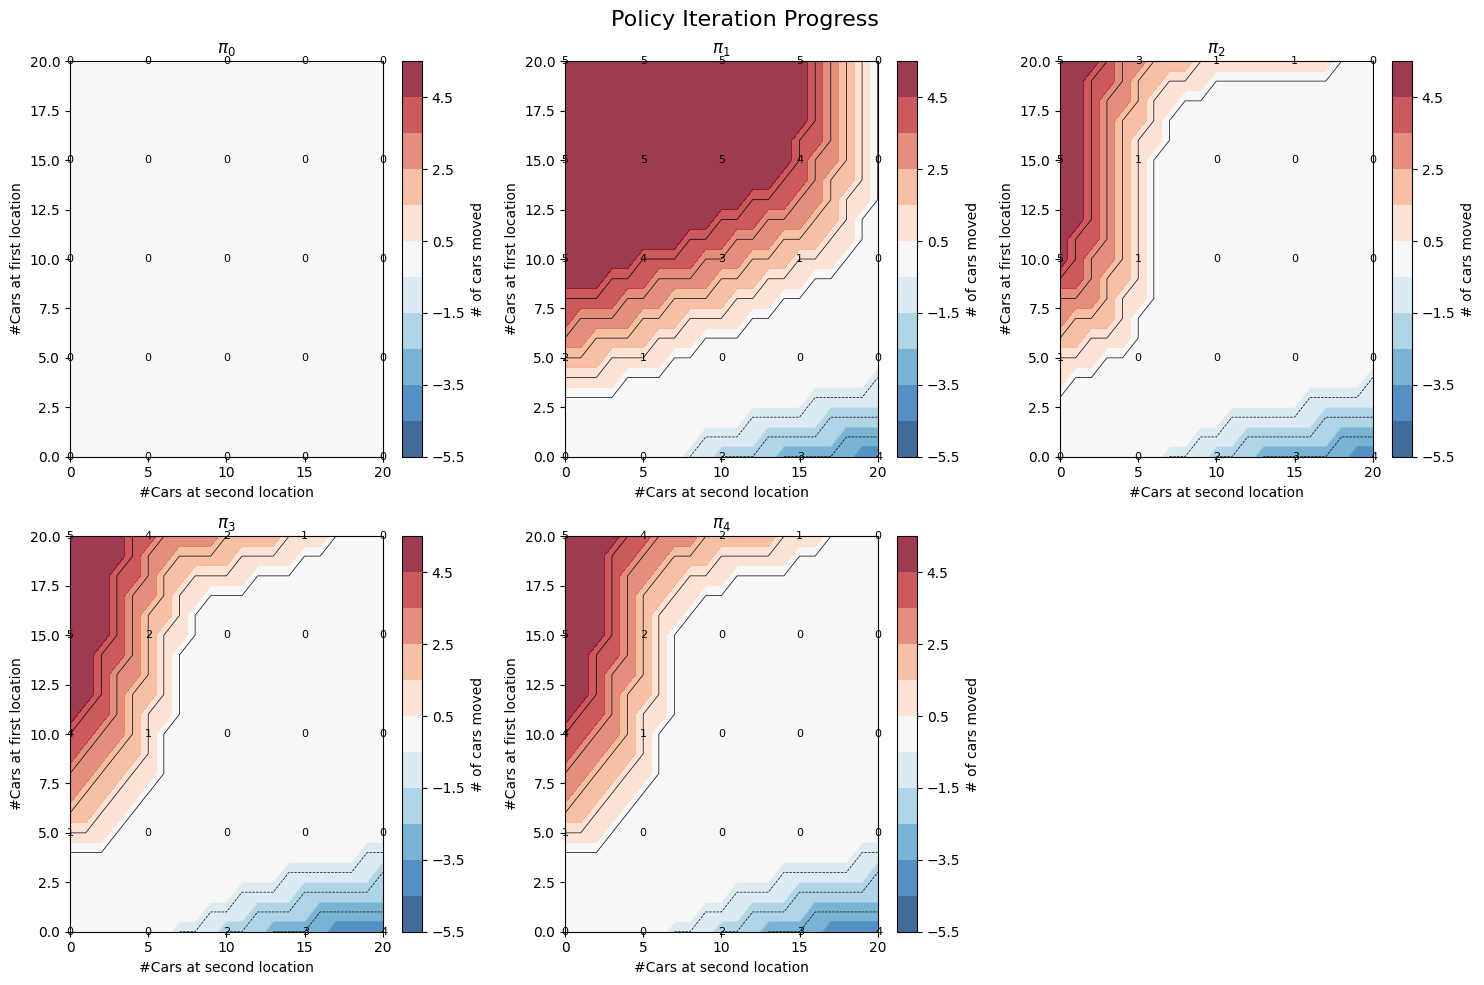

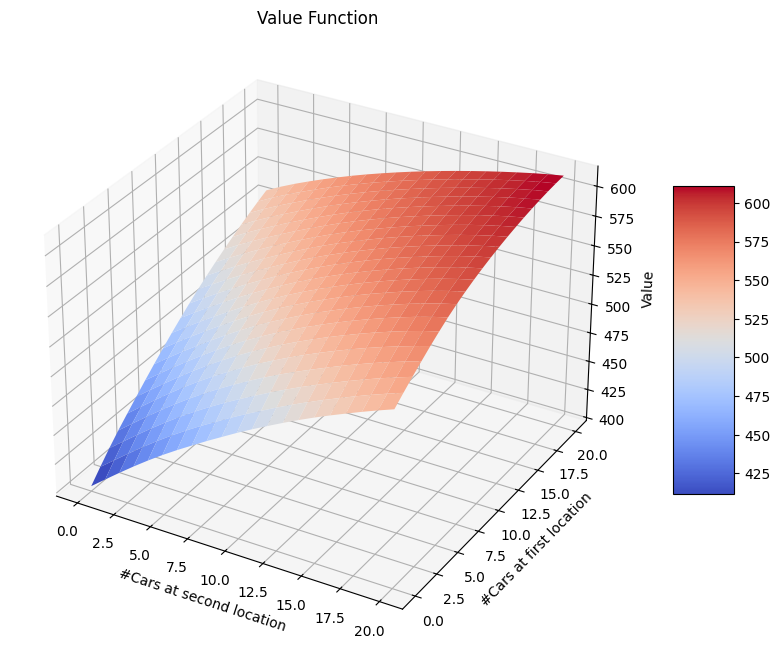

In [ ]:
policy_orig, V_orig, policies_orig = policy_iteration(modified=False, theta=1.0)
 
plot_policies(policies_orig)
plot_value_function(V_orig)

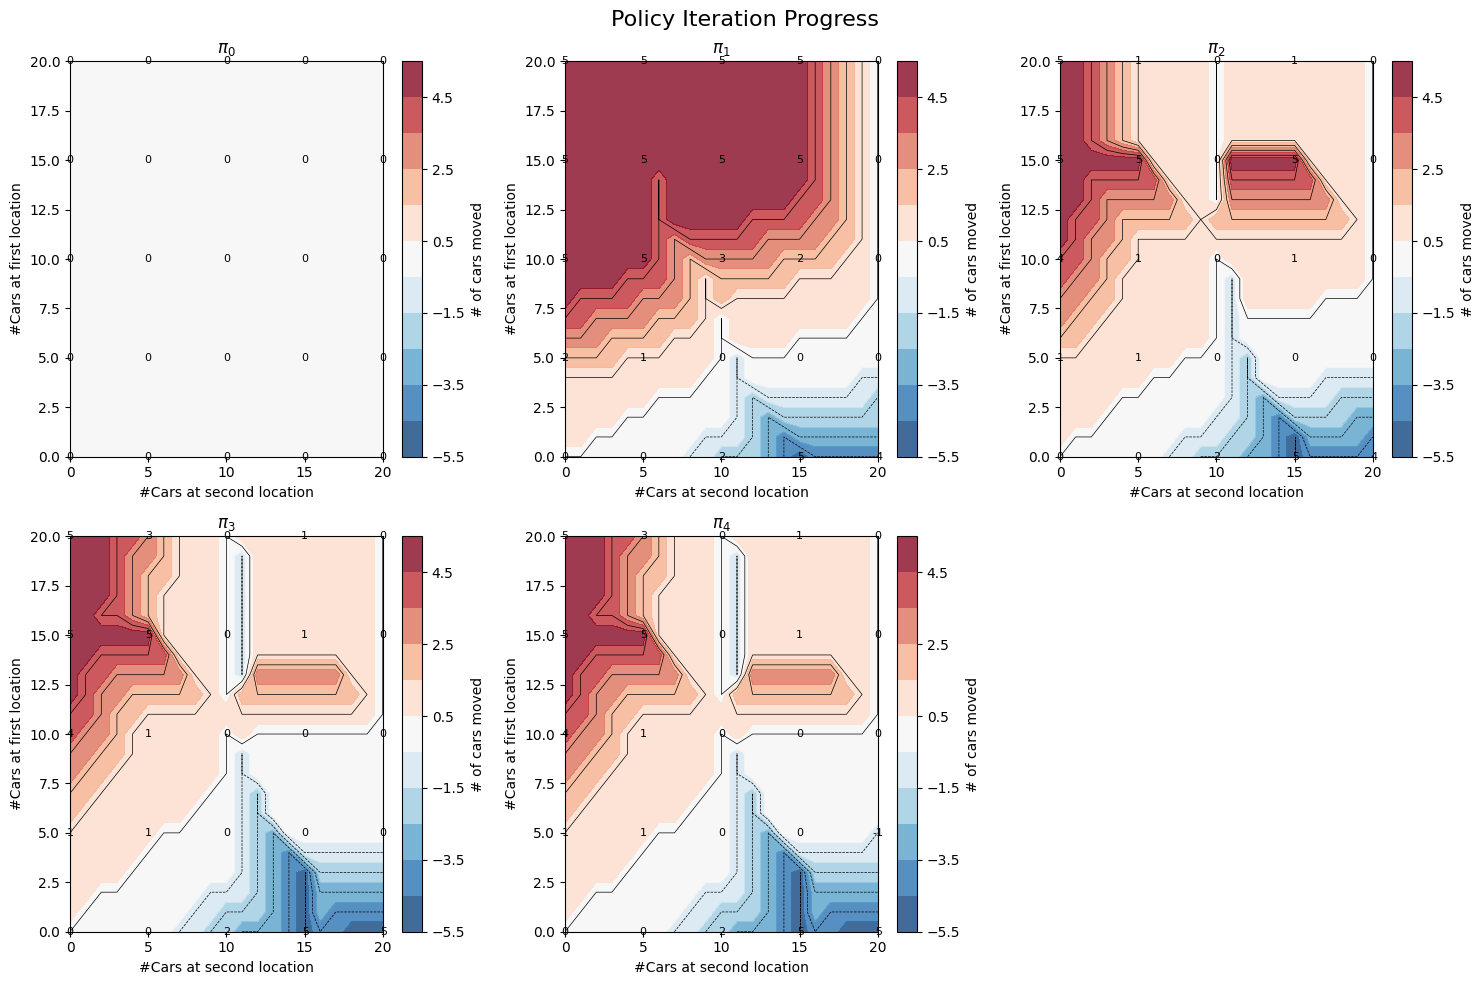

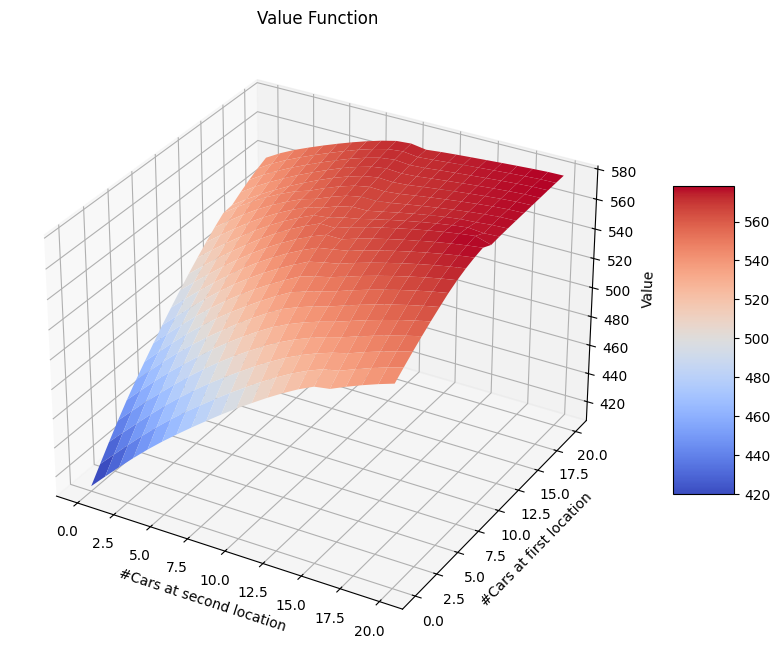

In [113]:
policy_mod, V_mod, policies_mod = policy_iteration(modified=True, theta=1.0)

plot_policies(policies_mod)
plot_value_function(V_mod)

### Code for Exercise 4.9


In [ ]:
def value_iteration_gamblers_problem(p_h, theta=1e-10, gamma=1.0):
    V = np.zeros(101)

    V[100] = 1.0  # Terminal state with goal reached has reward +1

    value_history = [V.copy()]
    sweep = 0

    while True:
        delta = 0
        sweep += 1

        for s in range(1, 100):  # 1 to 99
            v = V[s]

            max_stake = min(s, 100 - s)

            action_values = []

            for a in range(1, max_stake + 1):
                action_values.append(p_h * V[s + a] + (1 - p_h) * V[s - a])

            V[s] = np.max(action_values)

            delta = max(delta, abs(v - V[s]))

        value_history.append(V.copy())

        if delta < theta:
            print(f"Converged after {sweep} sweeps")
            break

    policy = np.zeros(101, dtype=int)

    for s in range(1, 100):
        max_stake = min(s, 100 - s)

        actions = np.arange(max_stake + 1)

        action_values = []

        for a in actions:
            action_values.append(p_h * V[s + a] + (1 - p_h) * V[s - a])

        policy[s] = actions[np.argmax(np.round(action_values[1:], 5)) + 1]

    return V, policy, value_history

In [ ]:
def plot_gamblers_results(p_h, V, policy, value_history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(range(101), V, linewidth=2, label="Final value function", color="black")

    sweep_indices = (
        [1, 2, 3, 32] if len(value_history) > 32 else [1, 2, 3, len(value_history) - 1]
    )

    colors = ["green", "red", "blue", "orange"]

    for i, (sweep_idx, color) in enumerate(zip(sweep_indices, colors)):
        if sweep_idx < len(value_history):
            ax1.plot(
                range(101),
                value_history[sweep_idx],
                linewidth=1.5,
                alpha=0.7,
                label=f"sweep {sweep_idx}",
                color=color,
            )

    ax1.set_xlabel("Capital", fontsize=12)
    ax1.set_ylabel("Value estimates", fontsize=12)
    ax1.set_title(f"Value Function (p_h = {p_h})", fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.bar(range(101), policy, width=1.0, edgecolor="black", linewidth=0.5)
    ax2.set_xlabel("Capital", fontsize=12)
    ax2.set_ylabel("Final policy (stake)", fontsize=12)
    ax2.set_title(f"Final Policy (p_h = {p_h})", fontsize=14)
    ax2.grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    plt.show()

Converged after 32 sweeps


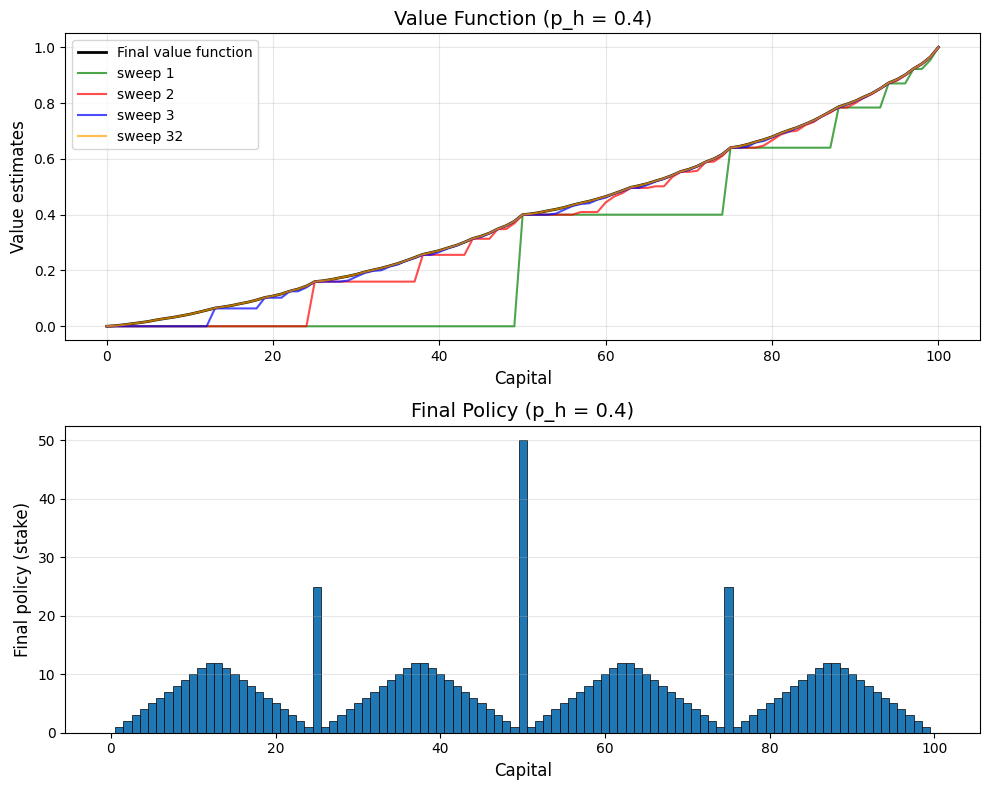

In [ ]:
V_25, policy_25, history_25 = value_iteration_gamblers_problem(p_h=0.4, theta=1e-18)

plot_gamblers_results(0.4, V_25, policy_25, history_25)

Converged after 27 sweeps


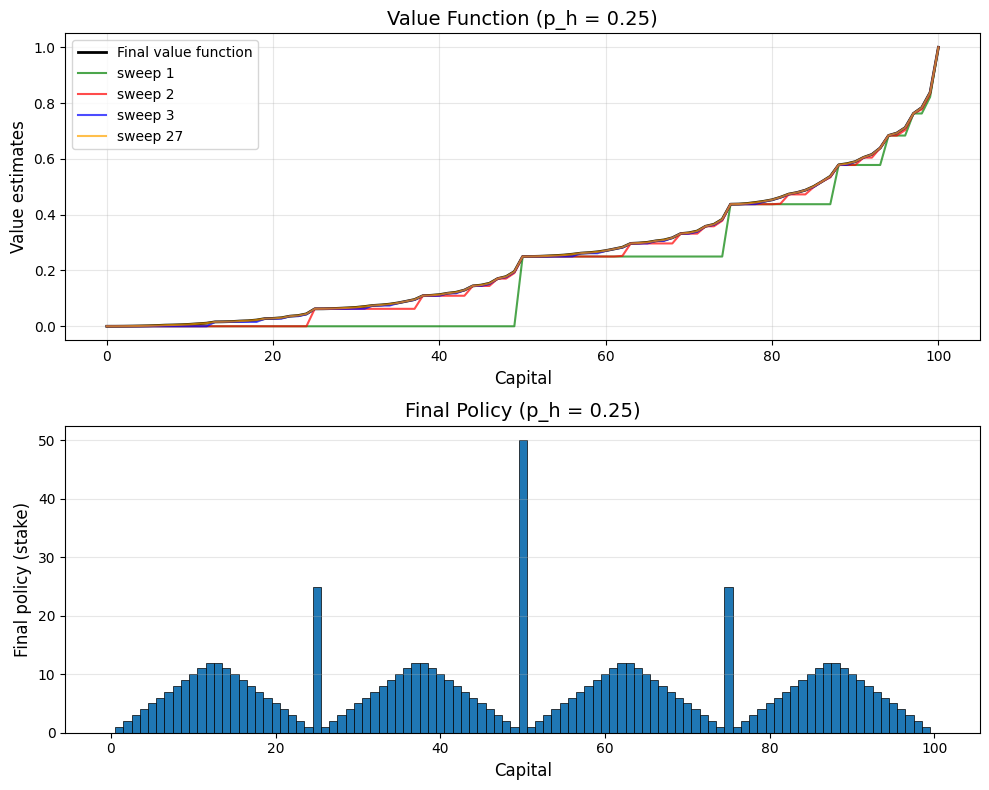

In [ ]:
V_25, policy_25, history_25 = value_iteration_gamblers_problem(p_h=0.25, theta=1e-18)

plot_gamblers_results(0.25, V_25, policy_25, history_25)

Converged after 3028 sweeps


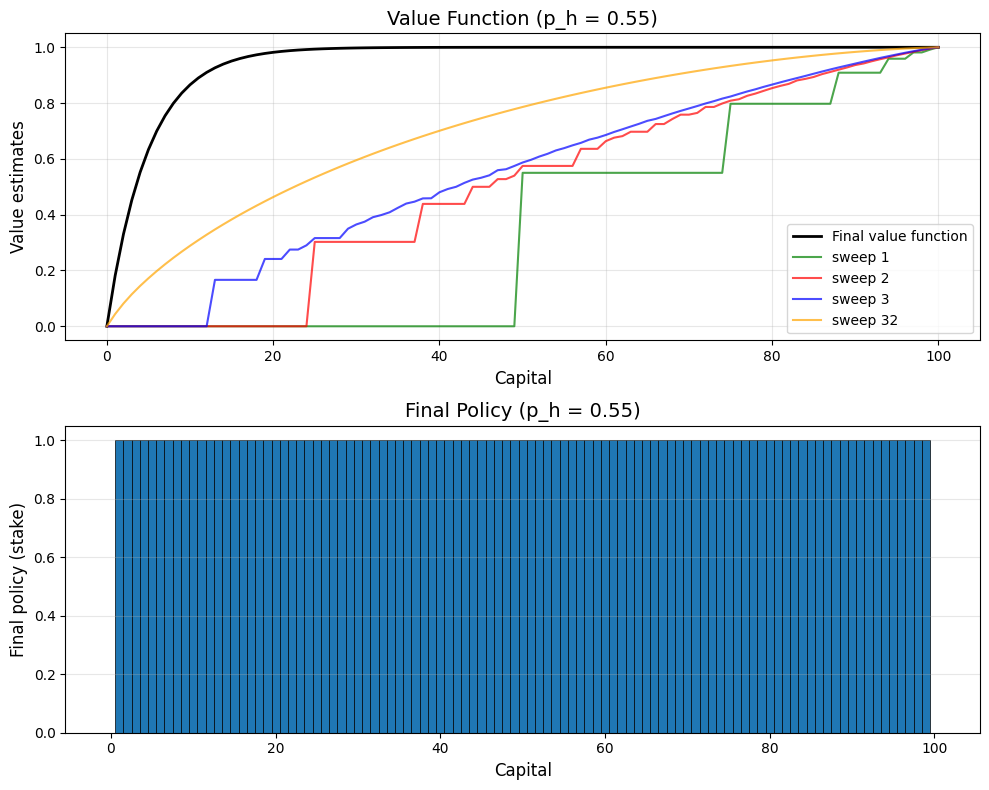

In [ ]:
V_55, policy_55, history_55 = value_iteration_gamblers_problem(p_h=0.55, theta=1e-18)

plot_gamblers_results(0.55, V_55, policy_55, history_55)